<a href="https://colab.research.google.com/github/modhudeb/Face-Detection-Custom-Model/blob/main/Face_Recognition_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install deepface

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 32.5 MB/s eta 0:00:00


In [ ]:
import skimage
from skimage import io, transform, exposure, color
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
# from retinaface import RetinaFace
import mediapipe as mp

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.metrics import classification_report

# Code

## Preprocess

In [ ]:
os.chdir('/content/drive/MyDrive/data')

In [ ]:
os.listdir()

['TestFace.pkl', 'trainFaceLabelArcFace.npz']

In [ ]:
# These functions help to detect head and draw box around the head
# using mediapipe
def headOnly(imgArray):
  ih, iw, ax = imgArray.shape
  fd = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
  pros = fd.process(imgArray)
  if pros.detections:
    box = pros.detections[0].location_data.relative_bounding_box
    x,y,w,h = int(box.xmin*iw), int(box.ymin*ih), int(box.width*iw), int(box.height*ih)
    return imgArray[y:y+h, x:x+w]
  else:
    return None






### 1) Using Mediapipe for cropping head of the images <br>2) And Doing augmentation

In [ ]:
# using mediapipe
# This cell will crop the head of images and do augmentation
labels = []
images = []

for fold in os.listdir('mates/'):
  print('[%s]  Working'%fold, end='')
  imgs = os.listdir("mates/"+fold)
  for image in imgs:
    ipath = os.path.join('mates', fold, image)
    img = io.imread(ipath)
    try :
      img = headOnly(img)
      if img is None:
        print("\nError : ",ipath)
    except Exception as e:
      print(e)
      print("\nError : ",ipath)

    img = transform.resize(img, (224,224))
    #
    images.append(img)
    labels.append(fold)
    #
    images.append(transform.rotate(img, np.random.randint(5,10), mode='edge'))
    labels.append(fold)
    #
    images.append(np.fliplr(img))
    labels.append(fold)
    images.append(transform.rotate(img, np.random.randint(5,10), mode='edge'))
    labels.append(fold)
    #
    images.append(exposure.adjust_sigmoid(img, np.random.uniform(0.5,0.6), 10))
    labels.append(fold)
    images.append(exposure.adjust_gamma(img, np.random.uniform(0.5,0.7)))
    labels.append(fold)
    print(".", end='')
  print(' ')
  print("[%s]  Done"%fold)

In [ ]:
images = np.stack(images)
images.shape

In [ ]:
labels = np.array(labels)

In [ ]:
x1 = pd.Series(labels)
x1.value_counts()

In [ ]:
np.savez('trainFaceLabel.npz', arr1 = images, arr2 = labels)
# # to load
# mulArr = np.load('trainFaceLabelArcFace.npz')
# images = mulArr['arr1']
# labels = mulArr['arr2']

In [ ]:
# Transforming Labels to categorical value
labelEncode = LabelEncoder()
labels_code = labelEncode.fit_transform(labels)
code_name = {}
for i in range(len(labelEncode.classes_)):
  code_name[i] = labelEncode.classes_[i]


In [7]:
# It contains categorical value and their pair Label
code_name

{0: 'Towfic',
 1: 'Ibrahim',
 2: 'Masum',
 3: 'Modhu',
 4: 'Saroj',
 5: 'Rahat',
 6: 'Rohim',
 7: 'Shakil',
 8: 'Shakil.D',
 9: 'nonmates'}

In [ ]:
# We wannt to replace 'No Identity' labeled images to null (For simplicity)
repIdx = np.where(labels=='nonmates')[0]
images[repIdx] = np.zeros_like(images[0])


In [ ]:
labelEncode.classes_

array(['Goob', 'Ibrahim', 'Masum', 'Modhu', 'Mother', 'Rahat', 'Rohim',
       'Shakil', 'Shakil.D', 'nonmates'], dtype='<U8')

In [ ]:
"Ignore this Cell"

# # formula to change rgb image to gray
# images = np.dot(images[..., :3], [0.2989, 0.5870, 0.1140])

# # we need grayscale images in 3 channel shape to train CNN (it's rule)
# num_samples, height, width = images.shape
# # Add an extra dimension to make the images compatible with Conv2D
# images = images.reshape(num_samples, height, width, 1)

### Test dataset

In [ ]:
# Loading test dataset of images
df = pd.read_pickle('TestFace.pkl')
df['resized'] = df['images'].apply(lambda x : transform.resize(headOnly(x), (112,112)))


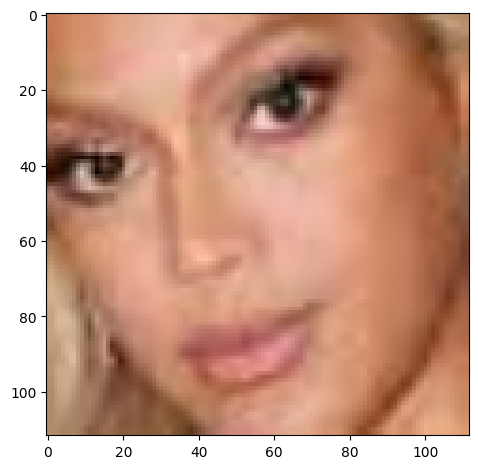

In [ ]:
# '9' is the pair categorical value of 'nonmate' test images
timg = df[df['labels']==9]['resized'].reset_index(drop = True)
io.imshow(timg[0])

In [ ]:
for x in df[df['labels']==9].index:
  df['resized'][x] = np.zeros_like(df['resized'][0])

In [ ]:
"ignore this cell if you don't want images to be converted in Grayscale"
# def rgb2gray(x):
#   x = np.dot(x[..., :3], [0.2989, 0.5870, 0.1140])
#   height, width = x.shape
#   return x.reshape(height, width, 1)

In [ ]:
# df['resized'] = df['resized'].apply(rgb2gray)

In [ ]:
xtest = np.stack(df['resized'])
ytest = np.stack(df['labels'])

In [ ]:
xtest.shape

(60, 112, 112, 3)

In [ ]:
from keras.regularizers import l2

## Cnn Model

In [ ]:
images[0].shape

(112, 112, 3)

In [ ]:
# DenseNet169,

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
!nvidia-smi

Fri Aug  4 11:19:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, min_delta=0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.1, patience=3)

<h3>Here i have tried different models, but have chosen the best optimized one for my dataset. <br><h5>-   The efficientNetV2S is pre trained model of Tensorflow which has given very high accuracy on my dataset

In [ ]:
# baseModel = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet',input_shape=images[0].shape, classes = 10)
# baseModel = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet',input_shape=images[0].shape, classes = 10)
# baseModel = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet',input_shape=images[0].shape, include_preprocessing=False)
# baseModel = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_shape=images[0].shape)
baseModel = tf.keras.applications.EfficientNetV2S(include_top=False, weights='imagenet',input_shape=images[0].shape, include_preprocessing=False, classes=len(set(labels_code)))
# baseModel.trainable = False
model = tf.keras.Sequential([
    baseModel,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2(0.01)),
    # tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2(0.01)),
    # tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer = l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(set(labels_code)), activation = 'softmax')
])


model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# transforming labels to one_hot_encoding
hot_labels = tf.keras.utils.to_categorical(labels_code, len(set(code_name)))

model.fit(images, hot_labels, batch_size = 16, epochs = 250, callbacks = [early_stopping, reduce_lr])  # callbacks = early_stopping


82420632/82420632 [==============================] - 5s 0us/step
Epoch 1/250
42/42 [==============================] - 81s 120ms/step - loss: 2.7756 - accuracy: 0.7262 - lr: 0.0010
Epoch 2/250
42/42 [==============================] - 4s 89ms/step - loss: 1.6089 - accuracy: 0.9003 - lr: 0.0010
Epoch 3/250
42/42 [==============================] - 4s 88ms/step - loss: 0.9666 - accuracy: 0.9182 - lr: 0.0010
Epoch 4/250
42/42 [==============================] - 4s 97ms/step - loss: 0.6646 - accuracy: 0.9375 - lr: 0.0010
Epoch 5/250
42/42 [==============================] - 4s 99ms/step - loss: 0.3718 - accuracy: 0.9628 - lr: 0.0010
Epoch 6/250
42/42 [==============================] - 4s 89ms/step - loss: 0.2310 - accuracy: 0.9792 - lr: 0.0010
Epoch 7/250
42/42 [==============================] - 4s 90ms/step - loss: 0.1508 - accuracy: 0.9807 - lr: 0.0010
Epoch 8/250
42/42 [==============================] - 4s 103ms/step - loss: 0.1952 - accuracy: 0.9702 - lr: 0.0010
Epoch 9/250
42/42 [=========

In [ ]:
# # using callbacks--

# checkpoint_filepath = "weights_at_19th_epoch.h5"
# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='loss',  # the metric you i want to monitor for saving the weights
#     save_best_only=True,
#     save_weights_only=True,
#     mode='max',
#     verbose=1,
# )

# model.load_weights('/content/drive/MyDrive/data/arcface_weights.h5', skip_mismatch=True, by_name=True)
# model.fit(images, labels_code, batch_size = 16, epochs = 50, callbacks=[early_stopping])

In [ ]:
images.shape

(672, 112, 112, 3)

In [ ]:
pred = model.predict(np.array([images[350]]))
code_name[np.argmax(pred)]

1/1 [==============================] - 5s 5s/step


'Modhu'

In [ ]:
# io.imshow(images[501])

In [ ]:
# del(images, labels, mulArr)

### Lets test on "Test dataset"

In [ ]:
xtest.shape

(60, 112, 112, 3)

In [ ]:
preds = model.predict(xtest)
preds = np.array([np.argmax(p) for p in preds])
# print(classification_report(df['labels'], preds))

2/2 [==============================] - 0s 29ms/step


In [ ]:
print(classification_report(ytest, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         3

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



😲Wow it is giving 100% accuracy on my test dataset also

In [5]:
code_name

{0: 'Towfic',
 1: 'Ibrahim',
 2: 'Masum',
 3: 'Modhu',
 4: 'Saroj',
 5: 'Rahat',
 6: 'Rohim',
 7: 'Shakil',
 8: 'Shakil.D',
 9: 'nonmates'}

In [ ]:
# io.imshow((xtest[23]*255).astype('uint8'))

In [ ]:
# This model takes (112,112,3) shape images
model.save('FaceRecog_friends.h5')

## Test with one picture

In [ ]:
# function to test single image

def rgb2gray(x):
  x = np.dot(x[..., :3], [0.2989, 0.5870, 0.1140])
  height, width = x.shape
  return x.reshape(height, width, 1)


def predictImg(imgPath):
  img = io.imread(imgPath)
  img = headOnly(img)
  img = transform.resize(img, (160,120))
  pred = model.predict(np.array([img]))
  return code_name[np.argmax(pred)], pred
  # pred = model.predict(np.array([img]))
  # return pred


1/1 [==============================] - 7s 7s/step


('Rohim',
 array([[0.01527347, 0.14391689, 0.01483663, 0.01758093, 0.00955899,
         0.05342019, 0.662509  , 0.0245941 , 0.0438435 , 0.01446622]],
       dtype=float32))

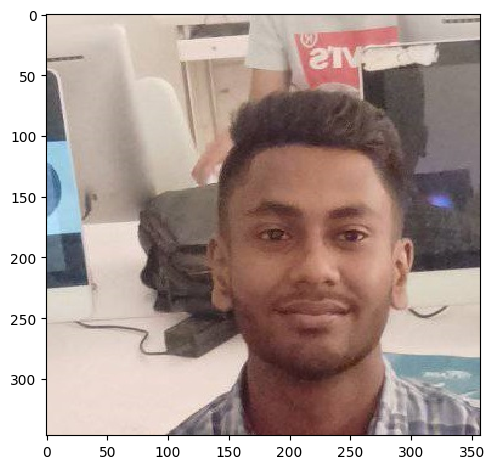

In [ ]:
io.imshow("/content/r.jpg")
predictImg("/content/r.jpg")

👆That is really my friend "Rohim", I had collected this image from his random posts to test my model. It is so accurate

🔻 Below i have tried ArcFace model to see how it works. Seems like ArcFace is not well enough for my dataset.

## ArcFace Model

In [ ]:
os.chdir('/content/')

In [ ]:
import ArcFaceColab

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, min_delta=0.0001)

In [ ]:
os.listdir()

['trainFaceLabel.npz',
 'TestFace.pkl',
 'FaceRecog_friends.h5',
 'arcface_weights.h5',
 'trainFaceLabelArcFace.npz',
 'FaceRecogMob_friends.h5',
 'FaceRecogMobArc_friends.h5']

In [ ]:
# Step 1: Load the pre-trained model
arcface_model = tf.keras.applications.MobileNetV2(weights=None, include_top=False)
arcface_model.load_weights("arcface_weights.h5", by_name = True)

num_classes = len(set(code_name))  # Replace this with the number of classes in your dataset

custom_head = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Combine the Arcface base model and the custom head
model = tf.keras.Model(inputs=arcface_model.input, outputs=custom_head(arcface_model.output))

In [ ]:
# Define the Arcface loss function
def arcface_loss(s, m):
    def loss(y_true, y_pred):
        embeddings = y_pred
        # labels = tf.argmax(y_true, axis=-1)
        theta_i = tf.reduce_sum(tf.multiply(embeddings, y_pred), axis=-1)
        mask = tf.one_hot(y_true, depth=tf.shape(embeddings)[-1])
        theta_j = tf.reduce_sum(tf.multiply(embeddings, mask), axis=-1)
        arcface_loss = -tf.reduce_mean(tf.math.log(tf.exp(s * (theta_i - m)) / (tf.reduce_sum(tf.exp(s * (theta_j - m)), axis=-1) + tf.exp(s * (theta_i - m)))))
        return arcface_loss
    return loss

# Step 6: Compile the model with the Arcface loss function
s = 64
m = 0.5

model.compile(optimizer='rmsprop', loss=arcface_loss(s, m), metrics=['accuracy'])


In [ ]:
hot_labels_code = tf.keras.utils.to_categorical(labels_code, num_classes=num_classes)

In [ ]:
model.fit(images, labels_code, epochs=50, batch_size=16)

In [ ]:
preds = model.predict(xtest)
preds = np.array([np.argmax(p) for p in preds])
print(classification_report(df['labels'], preds))

2/2 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         7
           2       0.15      1.00      0.26         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         3

    accuracy                           0.15        60
   macro avg       0.01      0.10      0.03        60
weighted avg       0.02      0.15      0.04        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
preds

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])